In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plot_utils

# Mistral E2E

## Loogle dataset

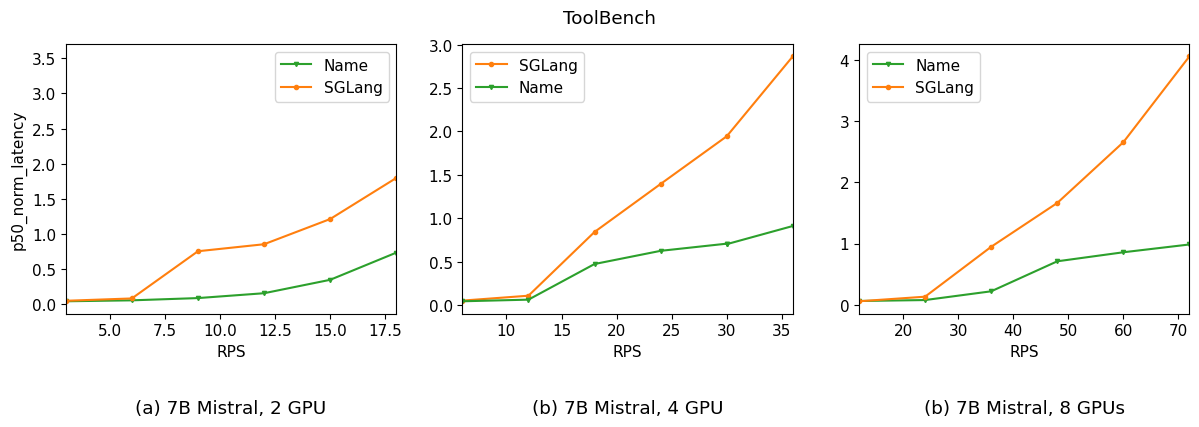

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(14.5, 3.5))
y_column = 'p50_norm_latency'

df_2r = plot_utils.read_e2e_csv_metrics('/mnt/ssd1/alm-os/sglang_multi_model/e2e/2r_test_toolbench_multi_exp/exp.csv')
for name, group in df_2r:
    ax[0].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    ax[0].set_xlim(3, 18)
    ax[0].set_xlabel('RPS')
    ax[0].legend()
    ax[0].set_title('(a) 7B Mistral, 2 GPU', y=-0.4)
    
df_4r = plot_utils.read_e2e_csv_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/e2e/4r_test_toolbench_multi_exp/exp.csv'])
for name, group in df_4r:
    if name != ('ROUND_ROBIN', ''):
        continue
    ax[1].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    ax[1].set_xlim(6, 36)
    ax[1].set_xlabel('RPS')
    ax[1].legend()
    ax[1].set_title('(b) 7B Mistral, 4 GPU', y=-0.4)
    
df_4r_ours = plot_utils.read_e2e_csv_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/e2e/4r_test_toolbench_multi_exp_steal_heavy/exp.csv', '/mnt/ssd1/alm-os/sglang_multi_model/e2e/4r_test_toolbench_multi_exp_steal_heavy_last2/exp.csv'])
for name, group in df_4r_ours:
    ax[1].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    ax[1].set_xlim(6, 36)
    ax[1].set_xlabel('RPS')
    ax[1].legend()
    ax[1].set_title('(b) 7B Mistral, 4 GPU', y=-0.4)
    
df_8r = plot_utils.read_e2e_csv_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/e2e/8r_test_toolbench_multi_exp/exp.csv'])
for name, group in df_8r:
    ax[2].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    ax[2].set_xlim(12, 72)
    ax[2].set_xlabel('RPS')
    ax[2].legend()
    ax[2].set_title('(b) 7B Mistral, 8 GPUs', y=-0.4)
    
ax[0].set_ylabel(y_column)
fig.suptitle('ToolBench')
plt.show()

## Loogle

Text(0.5, 0.98, 'Loogle')

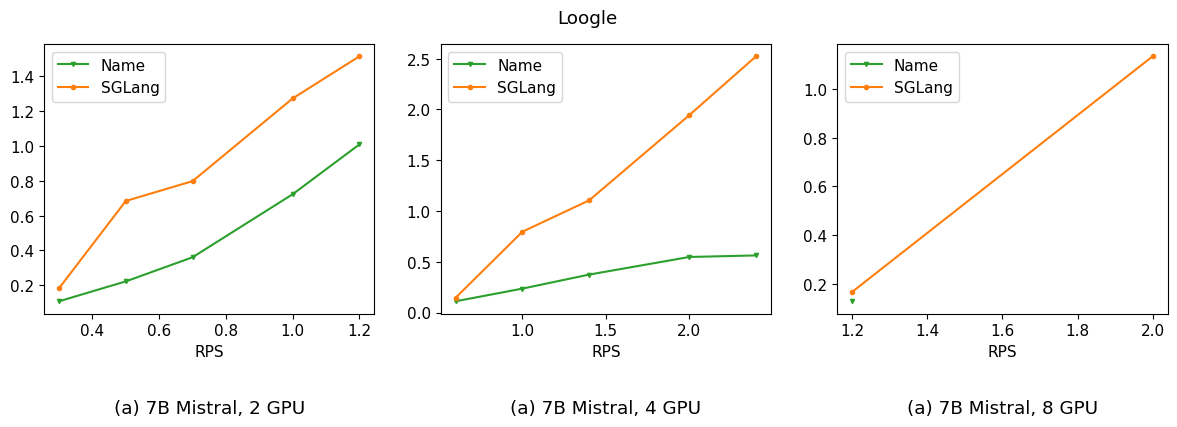

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14.5, 3.5))
y_column = 'p50_norm_latency'

df_2r = plot_utils.read_e2e_csv_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/e2e/2r_loogle_rich/exp.csv', '/mnt/ssd1/alm-os/sglang_multi_model/logs/debug_loogle/exp.csv'])
for name, group in df_2r:
    ax[0].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    # ax[0].set_xlim(3, 18)
    ax[0].set_xlabel('RPS')
    ax[0].legend()
    ax[0].set_title('(a) 7B Mistral, 2 GPU', y=-0.4)
    
df_4r = plot_utils.read_e2e_csv_metrics('/mnt/ssd1/alm-os/sglang_multi_model/e2e/4r_loogle_rich/exp.csv')
for name, group in df_4r:
    ax[1].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    # ax[0].set_xlim(3, 18)
    ax[1].set_xlabel('RPS')
    ax[1].legend()
    ax[1].set_title('(a) 7B Mistral, 4 GPU', y=-0.4)
    
df_8r = plot_utils.read_e2e_csv_metrics('/mnt/ssd1/alm-os/sglang_multi_model/e2e/8r_loogle_rich/exp.csv')
for name, group in df_8r:
    ax[2].plot(group['rps'], group[y_column],
               **plot_utils.policy_mapping[':'.join(name)])
    # ax[0].set_xlim(3, 18)
    ax[2].set_xlabel('RPS')
    ax[2].legend()
    ax[2].set_title('(a) 7B Mistral, 8 GPU', y=-0.4)

fig.suptitle('Loogle')